# Chapter 13 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import expit, logit, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

Set seed

In [5]:
rng = np.random.default_rng(RANDOM_SEED)

## 13.1 Example: Multilevel tadpoles

In [6]:
# load the data
frogs = load_data(REEDFROGS_FILE, delimiter=";")

We start with the single level model.

In [7]:
coords = {
    "tank": frogs.index,
}
with pm.Model() as m13_1:
    # data
    tank_idx = pm.MutableData("tank_idx", frogs.index, dims="tank")
    density = pm.MutableData("density", frogs.density, dims="tank")

    # prior
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="tank")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[tank_idx]), dims="tank")

    # likelihood
    surv = pm.Binomial("surv", n=density, p=p, observed=frogs.surv, dims="tank")

    # inference button
    trace_13_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can plot the probability of survival posteriors against the observed survival probabilities

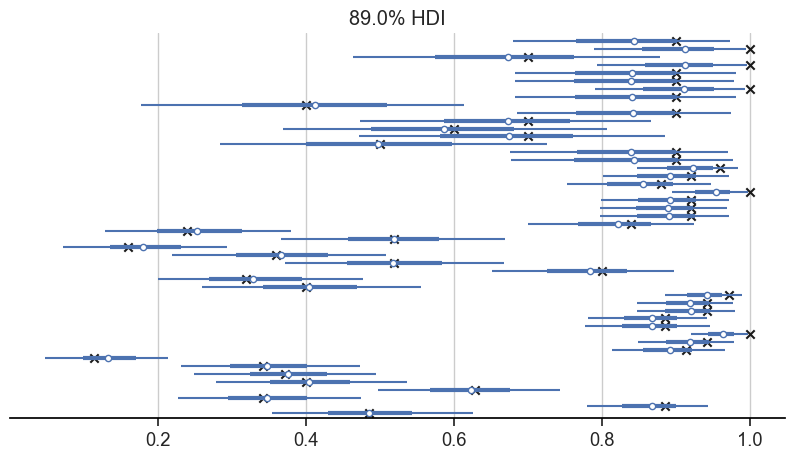

In [8]:
axs = az.plot_forest(
    trace_13_1,
    var_names="p",
    combined=True,
    hdi_prob=0.89,
    figsize=(10, 5),
)

ax = axs[0]
yticks = ax.get_yticks()
ax.scatter(frogs.propsurv, yticks[::-1], marker="x", color="k")

ax.get_yaxis().set_visible(False);

Note that there is shrinkage towards 0.5 coming from the priors on the alphas

Now let's try a multilevel model

In [9]:
coords = {
    "tank": frogs.index,
}
with pm.Model() as m13_2:
    # data
    tank_idx = pm.MutableData("tank_idx", frogs.index, dims="tank")
    density = pm.MutableData("density", frogs.density, dims="tank")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # prior
    alpha = pm.Normal("alpha", mu=alpha_bar, sigma=sigma, dims="tank")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[tank_idx]), dims="tank")
    p_bar = pm.Deterministic(
        "p_bar",
        pm.math.invlogit(alpha_bar),
    )

    # likelihood
    surv = pm.Binomial("surv", n=density, p=p, observed=frogs.surv, dims="tank")

    # inference button
    trace_13_2 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


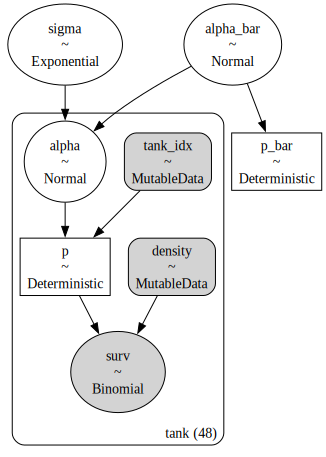

In [10]:
m13_2.to_graphviz()

We can plot the survival posteriors against those for the previous model and the observed values.
We also plot the posterior of `p_bar = invlogit(alpha_bar)`, the hyperparameter.

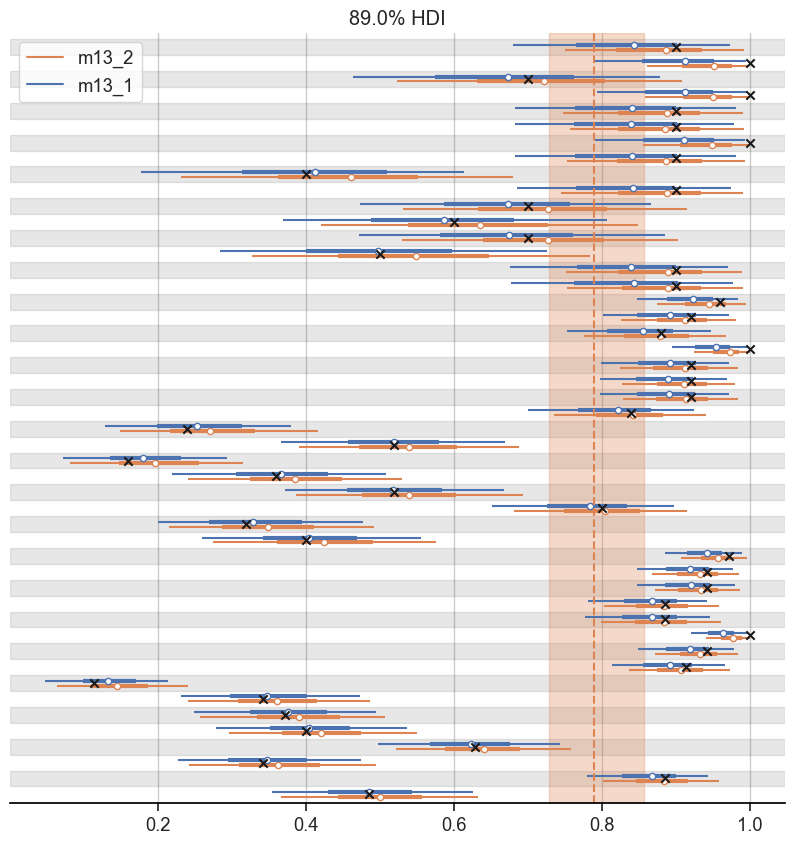

In [11]:
axs = az.plot_forest(
    [trace_13_1, trace_13_2],
    model_names=["m13_1", "m13_2"],
    var_names=["p"],
    combined=True,
    hdi_prob=0.89,
    figsize=(10, 10),
)

# plot observed values
ax = axs[0]
yticks = ax.get_yticks()
ax.scatter(
    frogs.propsurv, yticks[::-1], marker="x", color="k", zorder=2
)  # zorder brings it to the front

# plot posterior of p_bar
ax.axvline(trace_13_2.posterior.p_bar.mean(), color=colors[1], ls="--")
p_bar_hdi = az.hdi(trace_13_2.posterior.p_bar, hdi_prob=0.89)
ax.fill_betweenx(
    y=ax.get_ylim(),
    x1=p_bar_hdi.p_bar.sel(hdi="lower"),
    x2=p_bar_hdi.p_bar.sel(hdi="higher"),
    color=colors[1],
    alpha=0.3,
)

ax.get_yaxis().set_visible(False);

Note that the shrinkage is toward `p_bar` rather than towards 0.5.

## 13.2 Varying effects and the underfitting/overfitting trade-off

Let's simulate some pond data

In [12]:
alpha_bar_true = 1.5
sigma_true = 1.5
n_ponds = 60

# tadpoles in each pond
density = np.array([5, 10, 25, 35] * 15)
density.sort()

# true intercepts
alpha = rng.normal(loc=alpha_bar_true, scale=sigma_true, size=n_ponds)

# collect in a dataframe
ponds = pd.DataFrame(
    {
        "pond": np.arange(n_ponds),
        "density": density,
        "alpha_true": alpha,
    },
)
ponds["p_true"] = expit(ponds["alpha_true"])

# simulate survivors
ponds["surv"] = rng.binomial(n=ponds.density, p=ponds.p_true)

The non-pooled estimates are simply the empirical survival proportions:

In [13]:
ponds["p_nopool"] = ponds["surv"] / ponds["density"]

Now we build our hierarchical model

In [14]:
coords = {
    "pond": ponds.pond,
}
with pm.Model(coords=coords) as m13_3:
    # data
    pond_idx = pm.MutableData("pond_idx", ponds.pond, dims="pond")
    density = pm.MutableData("density", ponds.density, dims="pond")

    # hyperpriors
    alpha_bar = pm.Normal("alpha_bar", mu=0, sigma=1.5)
    sigma = pm.Exponential("sigma", lam=1)

    # priors
    alpha = pm.Normal("alpha", mu=alpha_bar, sigma=sigma, dims="pond")

    # model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[pond_idx]), dims="pond")
    p_bar = pm.Deterministic("p_bar", pm.math.invlogit(alpha_bar))

    # likelihood
    surv = pm.Binomial("surv", n=density, p=p, observed=ponds.surv, dims="pond")

    trace_13_3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


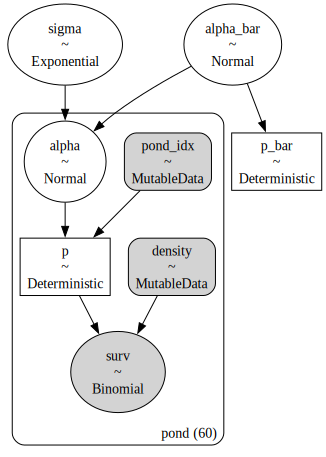

In [15]:
m13_3.to_graphviz()

In [16]:
# get pooled estimates
ponds["p_partpool"] = trace_13_3.posterior.p.mean(dim=["chain", "draw"])

# now get the errors
ponds["nopool_abs_err"] = (ponds["p_true"] - ponds["p_nopool"]).abs()
ponds["partpool_abs_err"] = (ponds["p_true"] - ponds["p_partpool"]).abs()

Let's compare the errors of the two models

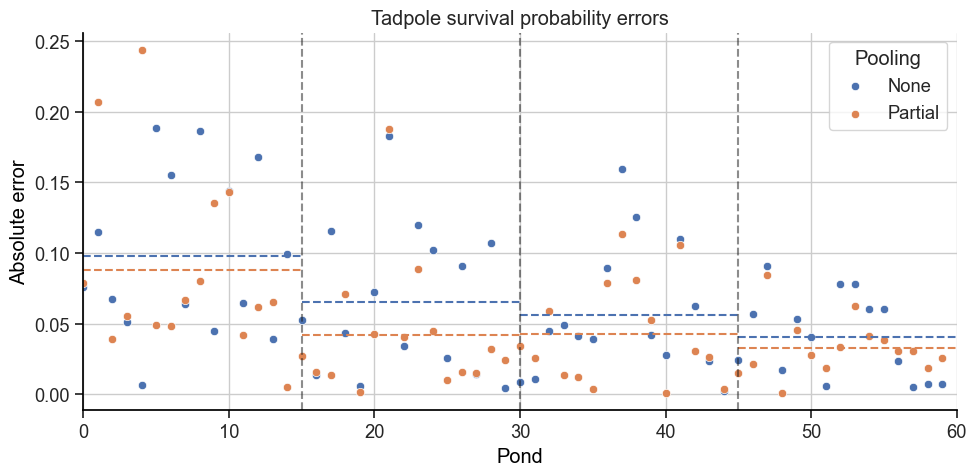

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

density_mean_errs = ponds.groupby("density")[["nopool_abs_err", "partpool_abs_err"]].mean()

thresholds = range(0, 61, 15)
for i, (density, mean_errs) in enumerate(density_mean_errs.iterrows()):
    ax.plot(
        thresholds[i : i + 2],
        [mean_errs["nopool_abs_err"], mean_errs["nopool_abs_err"]],
        color=colors[0],
        ls="--",
    )
    ax.plot(
        thresholds[i : i + 2],
        [mean_errs["partpool_abs_err"], mean_errs["partpool_abs_err"]],
        color=colors[1],
        ls="--",
    )


for threshold in thresholds[1:-1]:
    ax.axvline(threshold, ls="--", color="k", alpha=0.5)


sns.scatterplot(
    data=ponds, x="pond", y="nopool_abs_err", color=colors[0], label="None", ax=ax
)
sns.scatterplot(
    data=ponds, x="pond", y="partpool_abs_err", color=colors[1], label="Partial", ax=ax
)

ax.set(
    xlim=[0, 60],
    xlabel="Pond",
    ylabel="Absolute error",
    title="Tadpole survival probability errors",
)
ax.legend(title="Pooling")
plt.tight_layout();

The errors of the partially pooled model are reliably lower.